In [1]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sigpy.mri
import sigpy.plot

sitk_t1=sitk.ReadImage('../files/t1.nii.gz')
t1=sitk.GetArrayFromImage(sitk_t1)
print(t1.shape)

/home/oscar/Programs/miniconda3/envs/imrcenv/lib/python3.10/site-packages/sigpy/config.py:27: UserWarning: Importing cupy.cuda.cudnn failed. For more details, see the error stack below:
No module named 'cupyx.cudnn'
  warnings.warn(


(90, 256, 256)


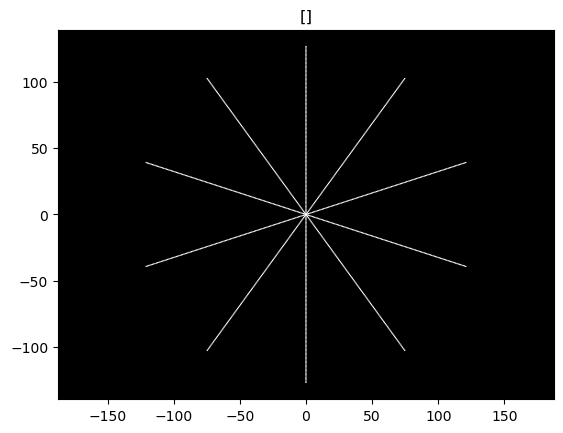

(10, 128, 2)

In [2]:
coord = sigpy.mri.radial([10,128,2],[256,256],golden=False)
sigpy.plot.ScatterPlot(coord)
coord.shape

The function `sigpy.mri.radial` outputs a set of spokes containing sampling points in a radial trajectory. Each spoke extends from the origin, but not across it. To set up the reconstruction with CT techniques we require that these spokes extend across the origin in k-space. The samples of k-space in each spoke correspond to a single projection in the sinogram at the angle at which said spoke is oriented in k-space. To convert the radial trajectory output by `sigpy` to a radial trajectrory with spokes that co across the origin, we do:

In [3]:
coord_across = []
ns2 = int(len(coord)/2) # Half the number of spokes in coord
for sp1, sp2 in zip(coord[:ns2], coord[ns2:]):
    coord_across.append(np.vstack([sp2[::-1], sp1]))
coord_across = np.array(coord_across)
coord_across.shape

(5, 256, 2)

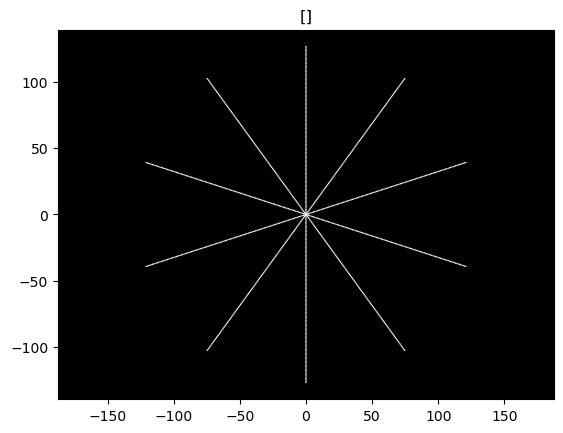

In [4]:
sigpy.plot.ScatterPlot(coord_across)

This has benn added as a function `get_radial_across` in the module `utils` of this project, for easy use

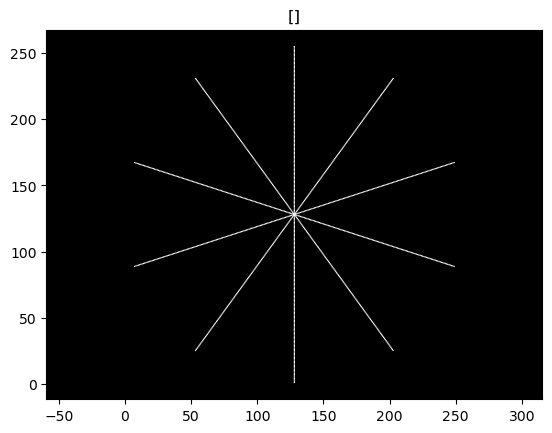

In [5]:
from utils import *
coord_across_tr = translate_spokes_to_img_coord(coord_across)

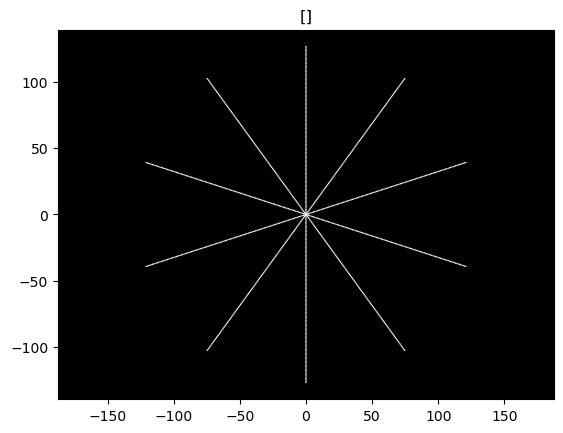

In [6]:
racc = get_radial_across(coord)
sigpy.plot.ScatterPlot(racc)

(180, 256, 2)


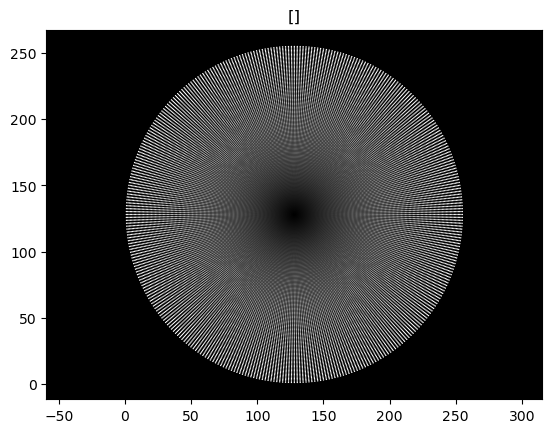

Acceleration factor: 1.4219401041666666


In [90]:
original = t1[45]
ksp = sigpy.fft(original)
N_spokes = 360
N_samples = 128
coord = sigpy.mri.radial([N_spokes, N_samples, 2], [256, 256], golden=False)
coord_across = []
ns2 = int(len(coord)/2) # Half the number of spokes in coord
for sp1, sp2 in zip(coord[:ns2], coord[ns2:]):
    coord_across.append(np.vstack([sp2[::-1], sp1]))
coord_across = np.array(coord_across)
print(coord_across.shape)
coord = coord_across
ramp_filter = (coord[..., 0]**2 + coord[..., 1]**2)**0.5
coord = translate_spokes_to_img_coord(coord, (256, 256))
sigpy.plot.ScatterPlot(coord, ramp_filter)
print(f"Acceleration factor: {65523/(N_spokes*N_samples)}")

Since the resulting spokes across the origin are evenly spaced (make sure `golden = False`), the angles at which they are can be easily obtained by simply doing

In [22]:
angles = np.linspace(0,180,int(N_spokes/2))
angles.shape

(180,)

We assume the CT acquisition goes only from 0º to 180º and we only have one acquisition to reconstruct. We sample the k-space without the filter, as this is going to be implemented via FBP. We only need the sinogram, which is obtained from the inverse Fourier transform of each spoke.

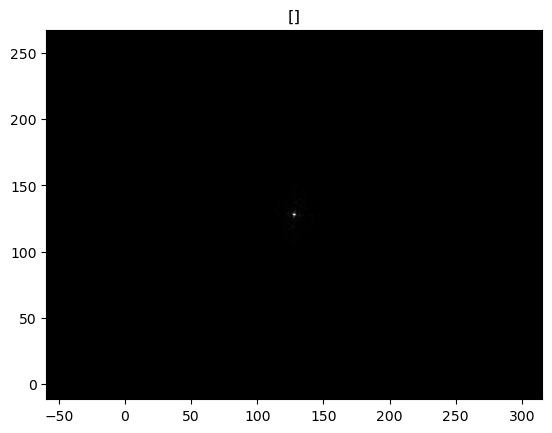

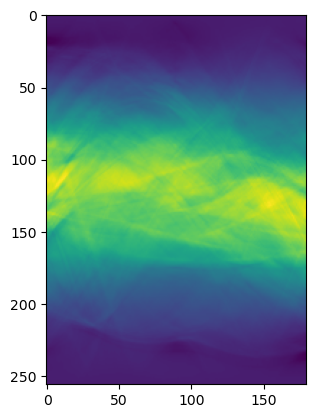

In [113]:
ksp_sampled = sigpy.interpolate(ksp, coord)
sino = np.array([sigpy.ifft(spoke, oshape=(256,), center=True) for spoke in ksp_sampled])
sigpy.plot.ScatterPlot(coord, ksp_sampled)
plt.imshow(np.flip(np.real(sino.T)))

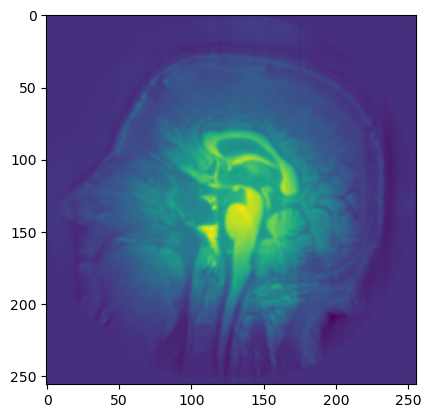

In [114]:
from skimage.transform import radon,iradon
reco_fbp = iradon(np.real(sino.T), theta=angles, filter_name='hann')
plt.imshow(np.flip(reco_fbp))

/home/oscar/Programs/miniconda3/envs/imrcenv/lib/python3.10/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


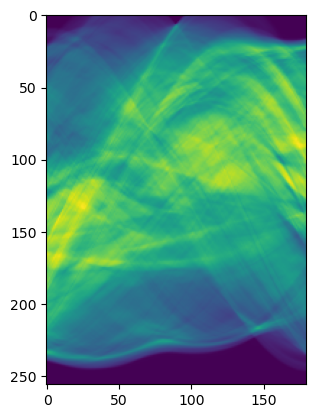

In [54]:
sino_ref = radon(original, angles)
plt.imshow(sino_ref)

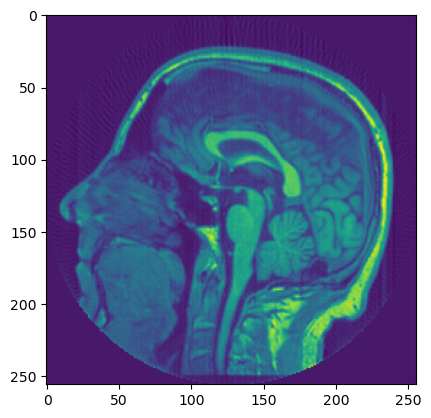

In [72]:
plt.imshow(iradon(sino_ref, angles, filter_name='ramp'))

In [39]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sigpy.mri
import sigpy.plot
from skimage.transform import iradon

from utils import *

sitk_t1=sitk.ReadImage('../files/t1.nii.gz')
t1=sitk.GetArrayFromImage(sitk_t1)

original = t1[45]
ksp = sigpy.fft(original)

n_ang = 180 # Equivalent to number of projections in the sinogram
n_samp = 280


In [11]:
def slice_sampling(ksp, n_angles, n_samples=256, dcomp=False):
    '''
    Sample k-space in a radial trajectory, with spokes going through the origin (slices).
    Return the sampled k_space and the coordinates of the sampling points.

    Note: This function obtains the sampled k-space in the correct shape to reconstruct
    with CT methods.
    '''
    coord = sigpy.mri.radial([n_angles*2, int(n_samples/2), 2], ksp.shape, golden=False)
    coord = get_radial_across(coord)
    if dcomp:
        dcf = ((coord[...,0])**2+(coord[...,1])**2)**0.5
    else:
        dcf = 1
    coord = translate_spokes_to_img_coord(coord, ksp.shape)
    sampled = sigpy.interpolate(ksp, coord)
    return (sampled*dcf), coord

(180, 280)


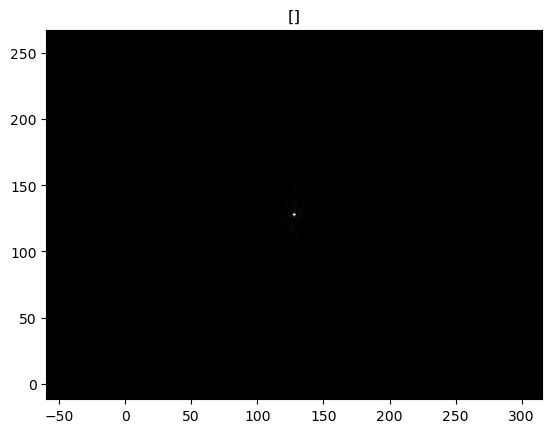

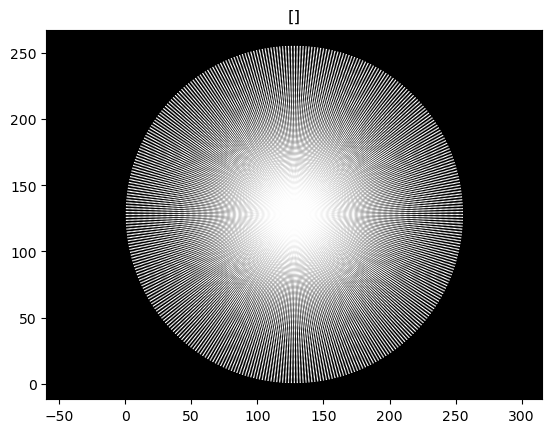

In [40]:
sampled, coord = slice_sampling(ksp, n_ang, n_samp, dcomp=False)
print(sampled.shape)
sigpy.plot.ScatterPlot(coord, sampled)
sigpy.plot.ScatterPlot(coord)

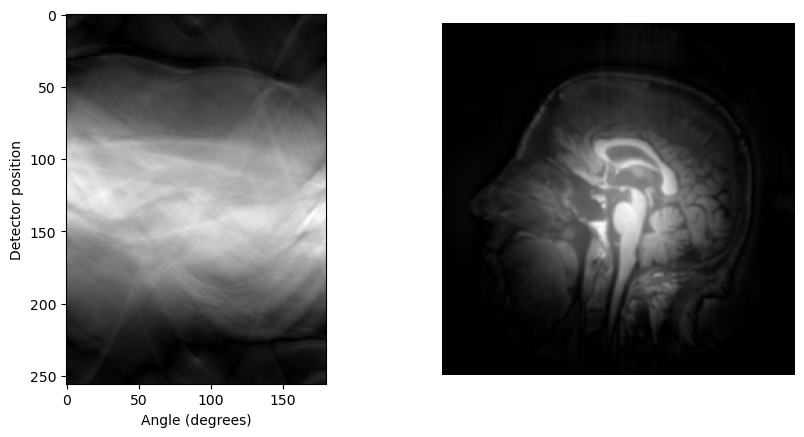

In [44]:
# Perform a single reconstruction

sino = np.array([sigpy.ifft(ksp_slice, oshape=(256,), center=True) for ksp_slice in sampled])
angles = np.linspace(0,180,n_ang)
reco = iradon(np.real(sino.T), theta=angles, filter_name='hann')
reco = np.flip(reco)
fig, axs = plt.subplots(1,2)
fig.set_figwidth(10)
axs[0].imshow(np.abs(sino.T), cmap='gray')
axs[0].set_xlabel('Angle (degrees)')
axs[0].set_ylabel('Detector position')
axs[1].axis('off')
axs[1].imshow(np.abs(reco), cmap='gray')
plt.show()

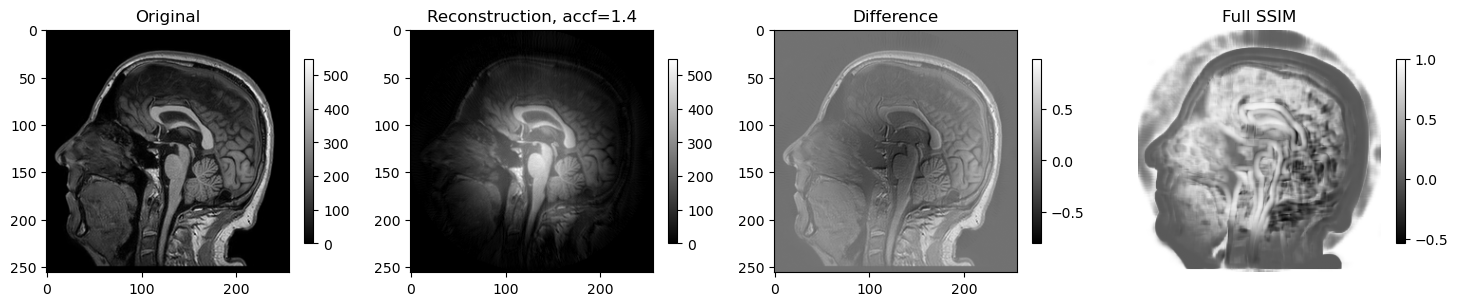

Acceleration factor: 1.4222222222222223,    Number of slices: 180
FBP rms reconstruction error: 0.186
PSNR = 50.121457948391665,    MSSIM = 0.4187381108717511


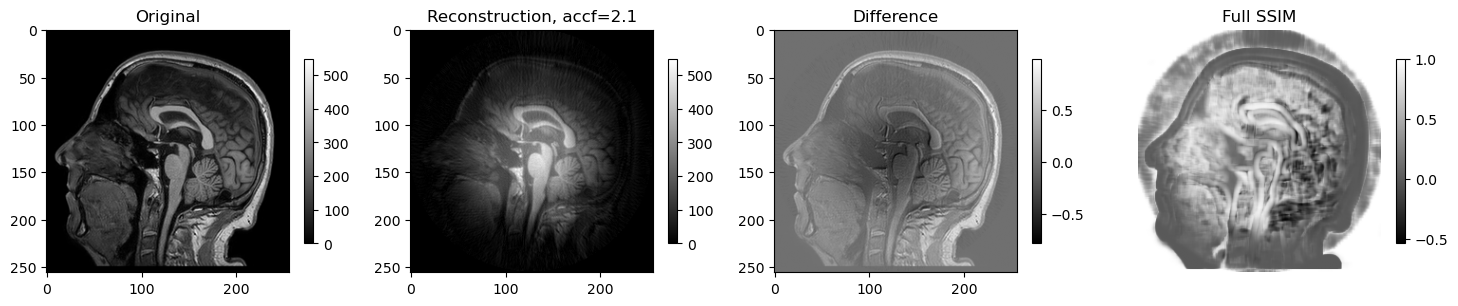

Acceleration factor: 2.1333333333333333,    Number of slices: 120
FBP rms reconstruction error: 0.185
PSNR = 50.166558794655664,    MSSIM = 0.3919840459943797


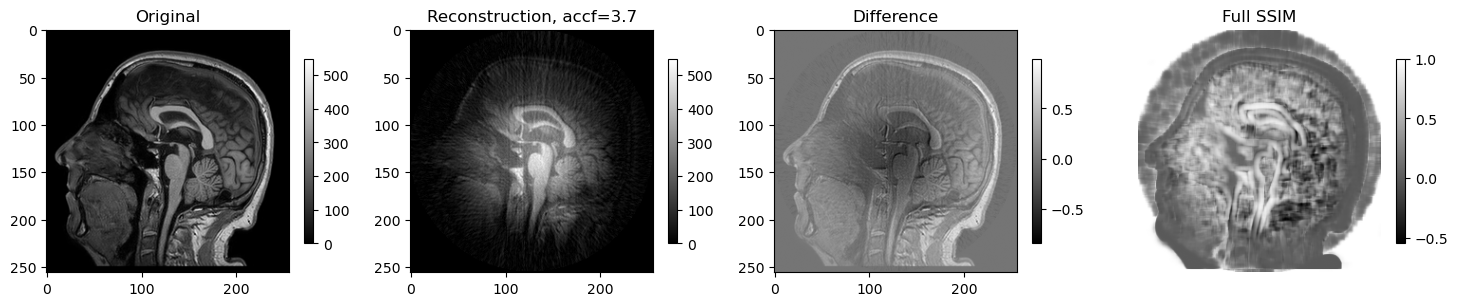

Acceleration factor: 3.657142857142857,    Number of slices: 70
FBP rms reconstruction error: 0.186
PSNR = 50.11405386575255,    MSSIM = 0.33853234604196636


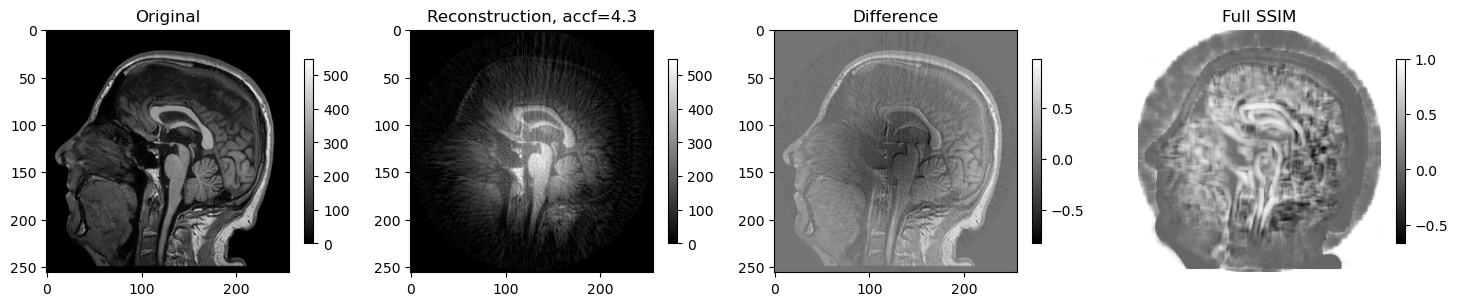

Acceleration factor: 4.266666666666667,    Number of slices: 60
FBP rms reconstruction error: 0.187
PSNR = 50.090989941544855,    MSSIM = 0.31892608603075173


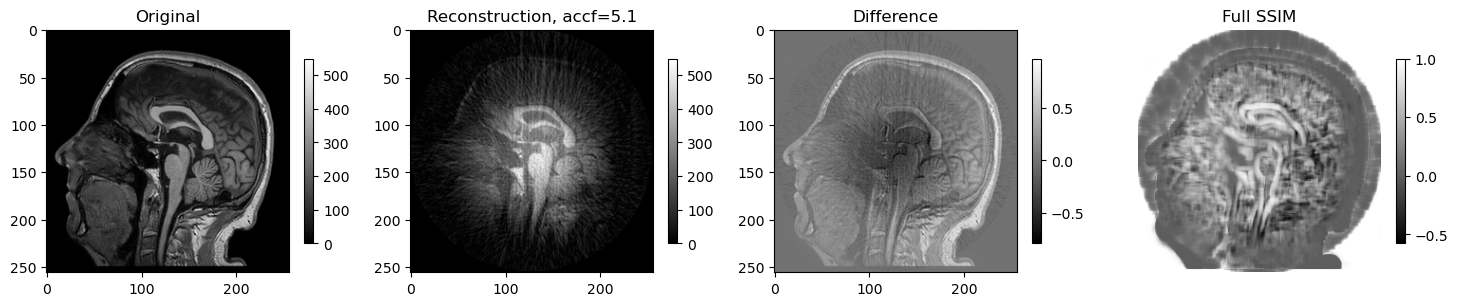

Acceleration factor: 5.12,    Number of slices: 50
FBP rms reconstruction error: 0.187
PSNR = 50.05835047384093,    MSSIM = 0.2974443218109087


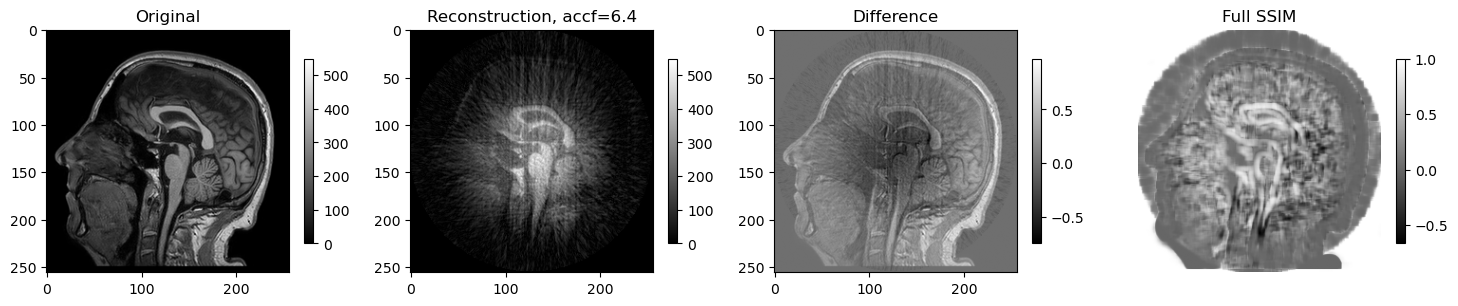

Acceleration factor: 6.4,    Number of slices: 40
FBP rms reconstruction error: 0.184
PSNR = 50.21912167245934,    MSSIM = 0.28085452838780134


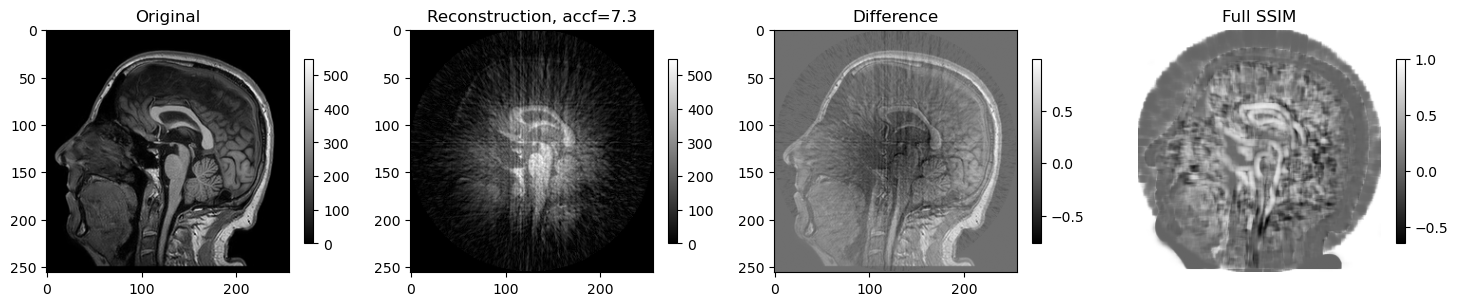

Acceleration factor: 7.314285714285714,    Number of slices: 35
FBP rms reconstruction error: 0.185
PSNR = 50.17942949566036,    MSSIM = 0.26359109511811357


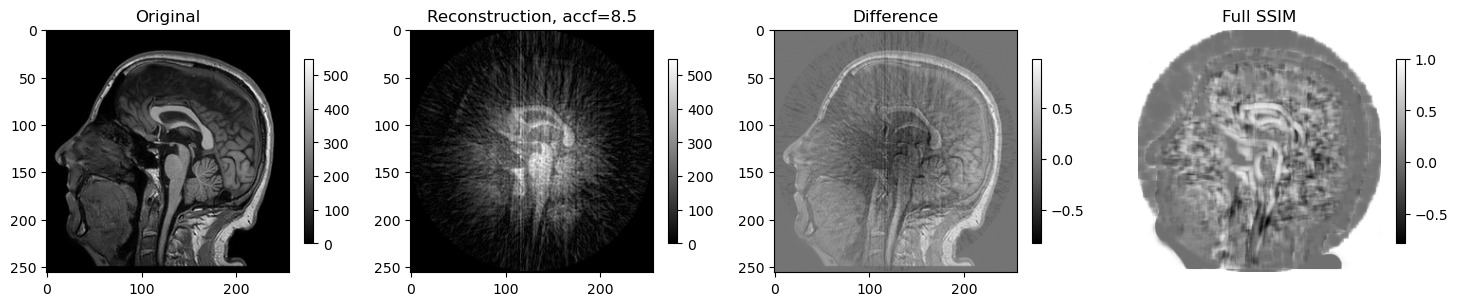

Acceleration factor: 8.533333333333333,    Number of slices: 30
FBP rms reconstruction error: 0.186
PSNR = 50.143326658369645,    MSSIM = 0.2520423771319612


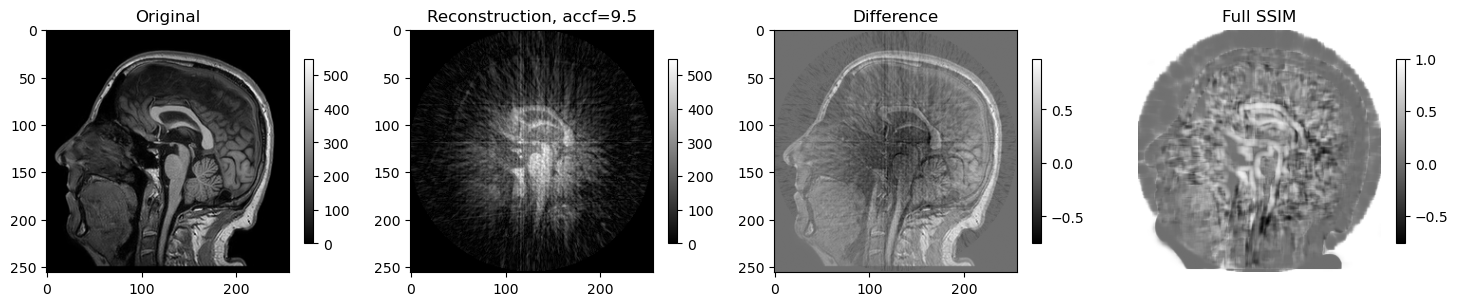

Acceleration factor: 9.481481481481481,    Number of slices: 27
FBP rms reconstruction error: 0.184
PSNR = 50.20465228065827,    MSSIM = 0.2462255607543171


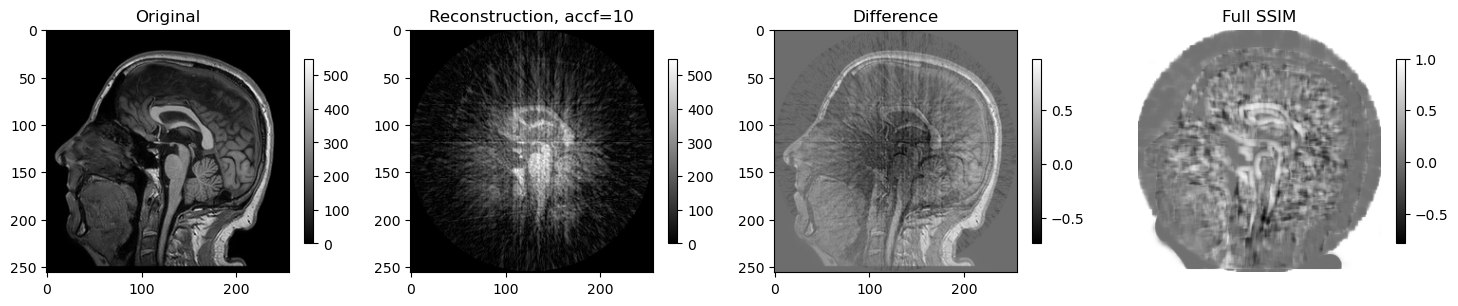

Acceleration factor: 10.24,    Number of slices: 25
FBP rms reconstruction error: 0.187
PSNR = 50.090112246386525,    MSSIM = 0.24083085434428095


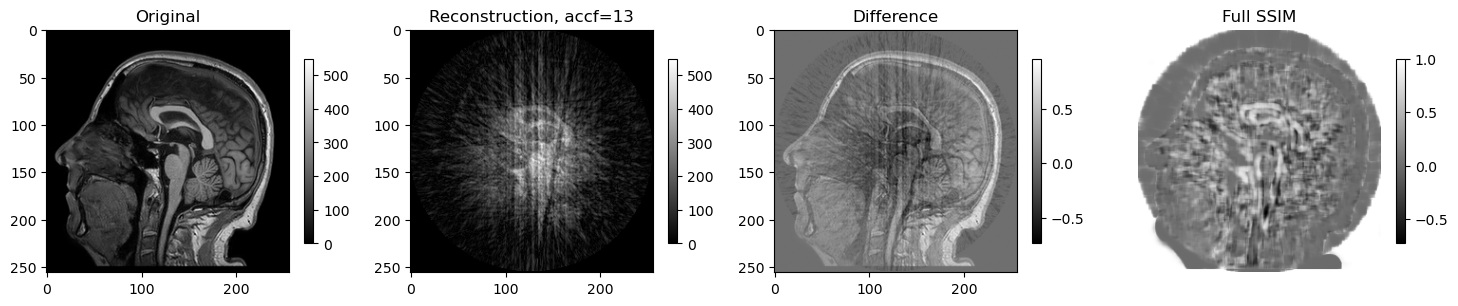

Acceleration factor: 12.8,    Number of slices: 20
FBP rms reconstruction error: 0.181
PSNR = 50.34992451582707,    MSSIM = 0.23646330750591224


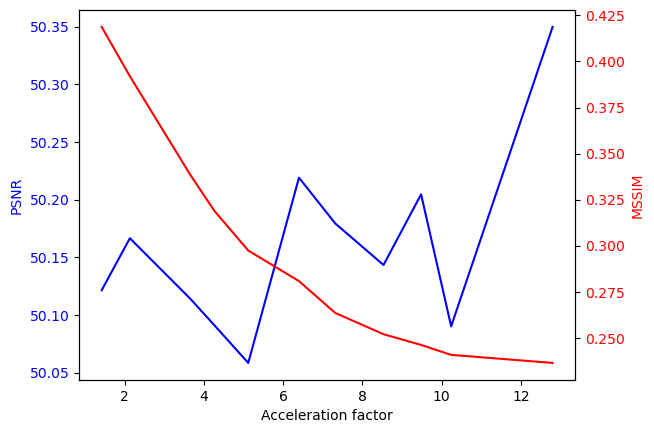

In [48]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
import sigpy.mri
import sigpy.plot
from skimage.transform import iradon
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

from utils import *

sitk_t1=sitk.ReadImage('../files/t1.nii.gz')
t1=sitk.GetArrayFromImage(sitk_t1)

original = t1[45]
ksp = sigpy.fft(original)

N_angles = [180, 120, 70, 60, 50, 40, 35, 30, 27, 25, 20] # Equivalent to number of projections in the sinogram
N_samples = 258 # Total samples in the slice, not the "spoke"
acc_factors = []
SNRs = []
SSIMs = []

for n in N_angles:
    acc_factors.append(256/n)
    ksp_sampled, coord = slice_sampling(ksp, n, N_samples, dcomp=False)
    sino = np.array([sigpy.ifft(ksp_slice, oshape=(256,), center=True) for ksp_slice in ksp_sampled])
    angles = np.linspace(0,180,n)
    reco = iradon(np.real(sino.T), theta=angles, filter_name='ramp')
    reco = np.flip(reco)
    reco = scale_by_max(reco, original)
    difference = (original - reco)/(original.max()-original.min())
    psnr = peak_signal_noise_ratio(original, reco)
    ssim, S = structural_similarity(original, reco, full=True, data_range=(original.max() - original.min()))
    # Plot
    fig, axs = plt.subplots(1, 4)
    fig.set_figwidth(18)
    plt.axis('off')
    figs = []
    figs.append(axs[0].imshow(original, cmap='gray',))
    figs.append(axs[1].imshow(reco, cmap='gray'))
    figs.append(axs[2].imshow(difference, cmap='gray'))
    figs.append(axs[3].imshow(S, cmap='gray'))
    for f, a in zip(figs,axs):
        fig.colorbar(f, ax=a, shrink=0.5)
    axs[0].set_title('Original')
    axs[1].set_title(f'Reconstruction, accf={256/n:.2g}')
    axs[2].set_title('Difference')
    axs[3].set_title('Full SSIM')
    plt.show()
    print(f"Acceleration factor: {256/n},    Number of slices: {n}")
    print(f'FBP rms reconstruction error: {np.sqrt(np.mean(difference**2)):.3g}')
    print(f"PSNR = {psnr},    MSSIM = {ssim}")
    print("============================================================")
    SNRs.append(psnr)
    SSIMs.append(ssim)
fig, ax1 = plt.subplots()
ax1.set_xlabel('Acceleration factor')
ax1.set_ylabel('PSNR', color='blue')
ax1.plot(acc_factors, SNRs, color='blue', label='PSNR')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.set_ylabel('MSSIM', color='red')
ax2.plot(acc_factors, SSIMs, color='red', label='MSSIM')
ax2.tick_params(axis='y', labelcolor='red')
# ax2.legend(bbox_to_anchor=(1.05, 1),loc='upper left', borderaxespad=0.)
plt.show()